# Basic Data Science in Python - Project
## Leihui Li; leihui@mpe.au.dk ##

This handin is indiviual and mandatory to pass the course.

Hand in this .ipynb file, no later than 10/11 kl 23:59. 

### Project description
For this project, you have almost no limitations. You are going to be working with a [smoke detection dataset](https://www.hackster.io/stefanblattmann/real-time-smoke-detection-with-ai-based-sensor-fusion-1086e6), to classify a fire alarm. The dataset is located in the data folder, as $\texttt{smoke\_detection.csv} $.

Remember before you begin, to inspect the data - i.e does it need cleaning, what are you working with? Also, remember to seperate the dataset in two - the labels ("Fire Alarm"), and the rest of the data.

Concretely, you should use your knowledge of testing, overfitting, and the pros and cons of different models, to predict Fire Alarm (0 for no alarm, 1 for alarm) from the different air quality measures. Try at least two different methods. You must reason about your choice of methods, as well as evaluate your results. Can you visualize your results somehow?

In [1]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
csv_data = pd.read_csv('../data/smoke_detection.csv')
print (csv_data.head)
features, labels = csv_data.iloc[:, :-1].to_numpy(), csv_data.iloc[:,-1].to_numpy().reshape(-1,1)
print (features.shape, labels.shape)

<bound method NDFrame.head of        Unnamed: 0         UTC  Temperature[C]  Humidity[%]  TVOC[ppb]  \
0               0  1654733331          20.000        57.36          0   
1               1  1654733332          20.015        56.67          0   
2               2  1654733333          20.029        55.96          0   
3               3  1654733334          20.044        55.28          0   
4               4  1654733335          20.059        54.69          0   
...           ...         ...             ...          ...        ...   
62625       62625  1655130047          18.438        15.79        625   
62626       62626  1655130048          18.653        15.87        612   
62627       62627  1655130049          18.867        15.84        627   
62628       62628  1655130050          19.083        16.04        638   
62629       62629  1655130051          19.299        16.52        643   

       eCO2[ppm]  Raw H2  Raw Ethanol  Pressure[hPa]  PM1.0  PM2.5  NC0.5  \
0            400

## 1. Decision Tree

The reason 

### 1.1 Implementation

In [3]:
# print (features.shape, labels.shape, type(features), type(labels))

from sklearn import tree
np.set_printoptions(precision=3, suppress=True)

X, y = features.copy(), labels.copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

print (f"Train data length:{X_train.shape}, Test data length:{X_test.shape}")
x_i = random.randint(0, len(X_test))
print (f"Here is an example: we select \"{x_i}\" th in Test data:")
print (f"feature:{X_train[x_i].tolist()} \nIts label is { y_train[x_i].tolist()}")

# Build decision tree and model
clf_model = tree.DecisionTreeClassifier(
    criterion='entropy', 
    splitter = 'random', 
    random_state=42, 
    max_depth=6,
    #min_impurity_decrease = 0.01,
    min_samples_leaf=1,
    min_samples_split=2)
clf_model = clf_model.fit(X_train, y_train)
# evalute by score
clf_score_sample, clf_score_test = clf_model.score(X_train,y_train), clf_model.score(X_test,y_test)     

print (f"The parameters of this decision tree are as follows:")
print (clf_model.get_params())

print (f"Training score: {clf_score_sample} test score: {clf_score_test}")

print (f"We select the {x_i} th among the test data:")
print (f"ground Truth:\n{X_test[x_i].tolist()} -> {y_test[x_i]}")
print (f"predict Result:\n{clf_model.predict(X_test[x_i].reshape(1, -1))}")

Train data length:(37578, 15), Test data length:(25052, 15)
Here is an example: we select "15513" th in Test data:
feature:[59411.0, 1655126833.0, 6.18, 47.71, 172.0, 451.0, 12767.0, 20560.0, 937.31, 2.01, 2.09, 13.85, 2.16, 0.049, 2525.0] 
Its label is [0]
The parameters of this decision tree are as follows:
{'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'entropy', 'max_depth': 6, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': 42, 'splitter': 'random'}
Training score: 0.9948640161796796 test score: 0.995409548139869
We select the 15513 th among the test data:
ground Truth:
[11638.0, 1654744969.0, 13.323, 53.57, 1069.0, 610.0, 12812.0, 19468.0, 939.054, 1.87, 1.94, 12.85, 2.005, 0.045, 11638.0] -> [1]
predict Result:
[1]


## 1.2 Visualization 

|--- feature_3 <= 46.32
|   |--- feature_8 <= 932.60
|   |   |--- feature_14 <= 137.53
|   |   |   |--- feature_2 <= 22.71
|   |   |   |   |--- class: 0
|   |   |   |--- feature_2 >  22.71
|   |   |   |   |--- feature_0 <= 50018.98
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- feature_0 >  50018.98
|   |   |   |   |   |--- feature_9 <= 744.62
|   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |--- feature_9 >  744.62
|   |   |   |   |   |   |--- class: 1
|   |   |--- feature_14 >  137.53
|   |   |   |--- class: 1
|   |--- feature_8 >  932.60
|   |   |--- feature_0 <= 34962.66
|   |   |   |--- feature_13 <= 0.04
|   |   |   |   |--- class: 0
|   |   |   |--- feature_13 >  0.04
|   |   |   |   |--- class: 1
|   |   |--- feature_0 >  34962.66
|   |   |   |--- feature_0 <= 53681.64
|   |   |   |   |--- feature_7 <= 20049.53
|   |   |   |   |   |--- class: 1
|   |   |   |   |--- feature_7 >  20049.53
|   |   |   |   |   |--- feature_6 <= 12840.73
|   |   |   |   |   |   |---

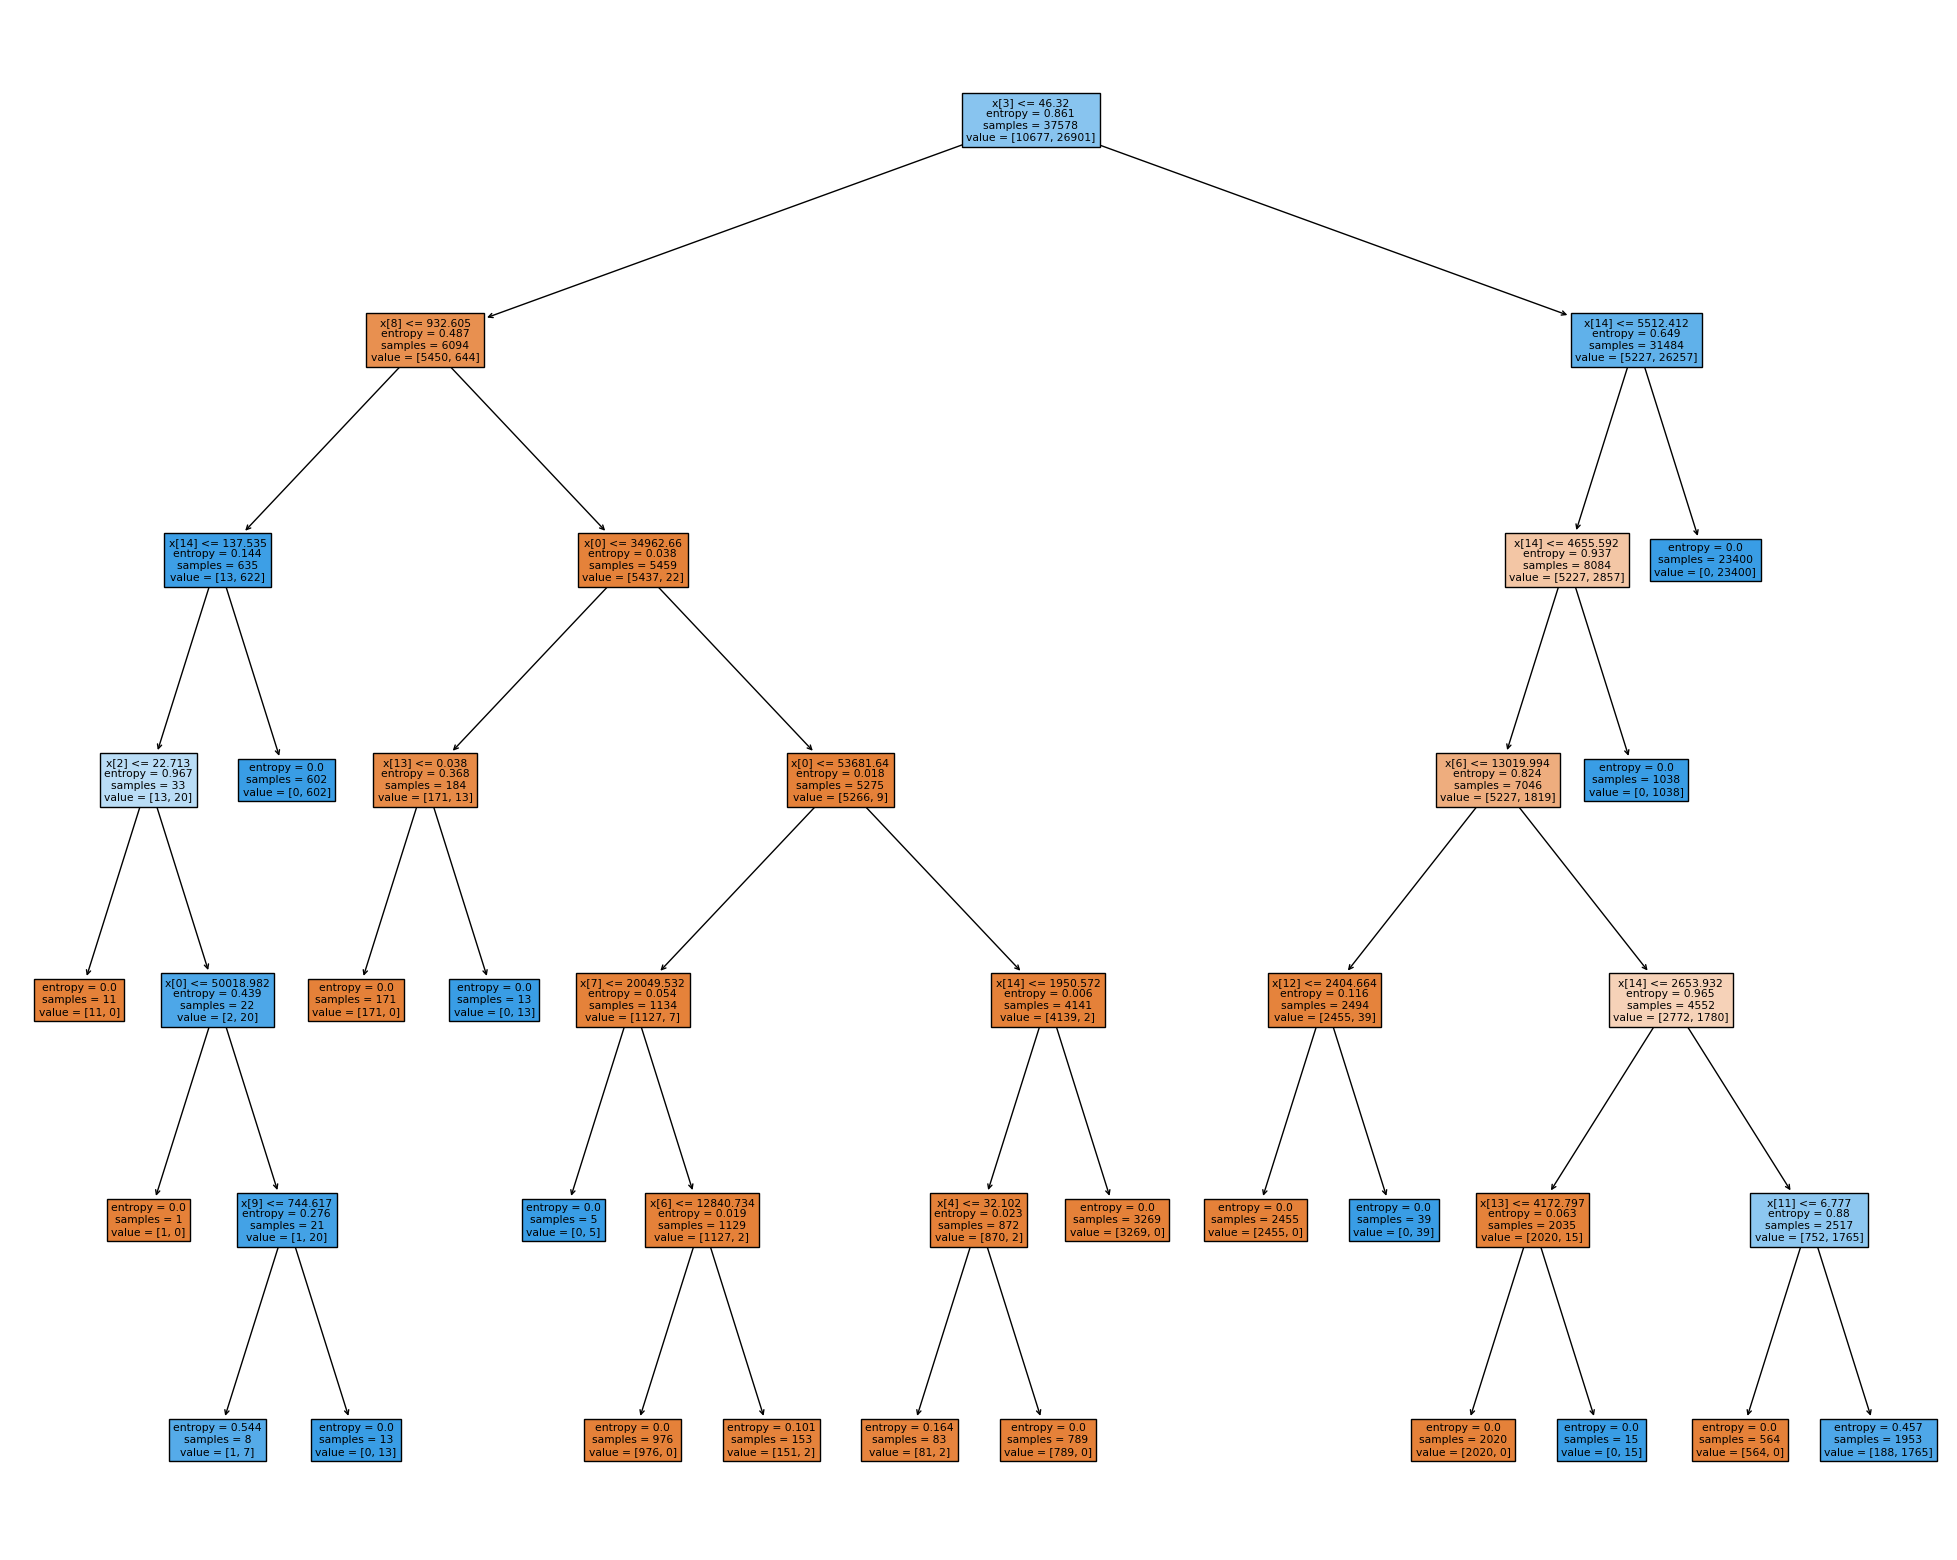

In [4]:
text_representation = tree.export_text(clf_model)
print(text_representation)

import sklearn
plt.figure(figsize=(25,20)) # Resize figure
sklearn.tree.plot_tree(clf_model, filled=True)
plt.show()

## 2. Neural Networks

## 2.1 Build the regression model using PyTorch

In [118]:
import torch, time
from tqdm.notebook import tqdm
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F

def run_epoch(model, optimizer, data_loader, loss_func, device, results, score_funcs, prefix="", desc=None):
    """
    model -- the PyTorch model / "Module" to run for one epoch
    optimizer -- the object that will update the weights of the network
    data_loader -- DataLoader object that returns tuples of (input, label) pairs.
    loss_func -- the loss function that takes in two arguments, the model outputs and the labels, and returns a score
    device -- the compute lodation to perform training
    score_funcs -- a dictionary of scoring functions to use to evalue the performance of the model
    prefix -- a string to pre-fix to any scores placed into the _results_ dictionary.
    desc -- a description to use for the progress bar.
    """
    running_loss = []
    y_true = []
    y_pred = []
    start = time.time()
    for inputs, labels in tqdm(data_loader, desc=desc, leave=False):
        #Move the batch to the device we are using.
        inputs = moveTo(inputs, device)
        labels = moveTo(labels, device)

        y_hat = model(inputs) #this just computed f_Θ(x(i))
        # Compute loss.
        loss = loss_func(y_hat, labels)

        if model.training:
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        #Now we are just grabbing some information we would like to have
        running_loss.append(loss.item())
        if score_funcs is not None:
            if len(score_funcs) > 0 and isinstance(labels, torch.Tensor):
                #moving labels & predictions back to CPU for computing / storing predictions
                labels = labels.detach().cpu().numpy()
                y_hat = y_hat.detach().cpu().numpy()
                #add to predictions so far
                y_true.extend(labels.tolist())
                y_pred.extend(y_hat.tolist())
    #end training epoch
    end = time.time()

    y_pred = np.asarray(y_pred)
    if len(y_pred.shape) == 2 and y_pred.shape[1] > 1: #We have a classification problem, convert to labels
        y_pred = np.argmax(y_pred, axis=1)
    #Else, we assume we are working on a regression problem

#     print(f'loss:{np.mean(running_loss)}')
    results[prefix + " loss"].append( np.mean(running_loss) )
    if score_funcs is not None:
        for name, score_func in score_funcs.items():
            try:
                results[prefix + " " + name].append( score_func(y_true, y_pred) )
            except:
                results[prefix + " " + name].append(float("NaN"))
    return end-start #time spent on epoch

def train_simple_network(model, loss_func, train_loader, test_loader=None, score_funcs=None,
                         epochs=20, device="cpu", checkpoint_file=None, _plt = None):
    to_track = ["epoch", "total time", "train loss"]
    if test_loader is not None:
        to_track.append("test loss")
    if score_funcs is not None:
        for eval_score in score_funcs:
            to_track.append("train " + eval_score )
            if test_loader is not None:
                to_track.append("test " + eval_score )

    total_train_time = 0 #How long have we spent in the training loop?
    results = {}
    #Initialize every item with an empty list
    for item in to_track:
        results[item] = []

    #SGD is Stochastic Gradient Decent.
    optimizer = torch.optim.SGD(model.parameters(), lr=0.03)
    #Place the model on the correct compute resource (CPU or GPU)
    model.to(device)
    for epoch in tqdm(range(epochs), desc="Epoch"):
        model = model.train()#Put our model in training mode

        total_train_time += run_epoch(model, optimizer, train_loader, loss_func, device, results, score_funcs, prefix="train", desc="Training")

        results["total time"].append( total_train_time )
        results["epoch"].append( epoch )

        if test_loader is not None:
            model = model.eval()
            with torch.no_grad():
                run_epoch(model, optimizer, test_loader, loss_func, device, results, score_funcs, prefix="test", desc="Testing")
#         _plt.clf()
#         _plt.plot(results['train loss'])
#         _plt.plot(results['test loss'])
#         _plt.show()
#         _plt.pause(0.1)
#         _plt.ioff()

    if checkpoint_file is not None:
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'results' : results
            }, checkpoint_file)
    
    return pd.DataFrame.from_dict(results)

class RegressionDataset(Dataset):
    def __init__(self, X, y):
        # super(Simple1DRegressionDataset, self).__init__()
        self.X = X.reshape(-1,13)
        self.y = y.reshape(-1,1)

    def __getitem__(self, index):
        return torch.tensor(self.X[index,:], dtype=torch.float32), torch.tensor(self.y[index], dtype=torch.float32)

    def __len__(self):
        return self.X.shape[0]
    
def moveTo(obj, device):
    """
    obj: the python object to move to a device, or to move its contents to a device
    device: the compute device to move objects to
    """
    if isinstance(obj, list):
        return [moveTo(x, device) for x in obj]
    elif isinstance(obj, tuple):
        return tuple(moveTo(list(obj), device))
    elif isinstance(obj, set):
        return set(moveTo(list(obj), device))
    elif isinstance(obj, dict):
        to_ret = dict()
        for key, value in obj.items():
            to_ret[moveTo(key, device)] = moveTo(value, device)
        return to_ret
    elif hasattr(obj, "to"):
        return obj.to(device)
    else:
        return obj

In [119]:
# Stratified dataset split in PyTorch
import random
import math
import torch.utils.data
from collections import defaultdict

def stratified_split(dataset : torch.utils.data.Dataset, labels, fraction, random_state=None):
    indices_per_label = defaultdict(list)
    for index, label in enumerate(labels):
        indices_per_label[label].append(index)
    first_set_indices, second_set_indices = list(), list()
    for label, indices in indices_per_label.items():
        n_samples_for_label = round(len(indices) * fraction)
        random_indices_sample = random.sample(indices, n_samples_for_label)
        first_set_indices.extend(random_indices_sample)
        second_set_indices.extend(set(indices) - set(random_indices_sample))
    first_set_inputs = torch.utils.data.Subset(dataset, first_set_indices)
    first_set_labels = list(map(labels.__getitem__, first_set_indices))
    second_set_inputs = torch.utils.data.Subset(dataset, second_set_indices)
    second_set_labels = list(map(labels.__getitem__, second_set_indices))
    return first_set_inputs, first_set_labels, second_set_inputs, second_set_labels

In [124]:
## Dataset preparation
device = torch.device("cpu")
# For this dataset, the index number and the UTC may not be helpful, so 13 features could be enough
in_features = 13
out_features = 2
node_num = 30
model = nn.Sequential(
    nn.Linear(in_features, node_num),#hidden layer
    nn.Tanh(),#activation
    nn.Linear(node_num, node_num),#hidden layer
    nn.Tanh(),#activation
    nn.Linear(node_num, out_features),#output layer
)
torch.manual_seed(42)
X, y = features.copy()[:,2:], labels.copy()
print (X.shape, y.shape)
dataset  = torch.utils.data.TensorDataset(
    torch.tensor(X, dtype=torch.float32).to(device),
    torch.tensor(y.flatten(), dtype=torch.long).to(device))
train_ratio = 0.8
num_of_train_rows = int(math.ceil(X.shape[0]*train_ratio)) # get sure to round up
num_of_test_rows = int(math.ceil(X.shape[0]*(1-train_ratio)))
print (f"{num_of_train_rows} and {num_of_test_rows} == {X.shape[0]}")

train_data, test_data = torch.utils.data.random_split(dataset , 
                                            lengths=[num_of_train_rows, num_of_test_rows])

# train_data, train_labels, test_data, test_labels = stratified_split(dataset, y, fraction=0.9)

training_loader = DataLoader(train, shuffle=True,batch_size=256)
testing_loader = DataLoader(test, shuffle=True, batch_size=256)

(62630, 13) (62630, 1)
50104 and 12526 == 62630


In [125]:
## Training
loss_func = nn.CrossEntropyLoss()
# plt.ion() 
results = train_simple_network(model, 
                               loss_func, training_loader, testing_loader, 
                               epochs=200, device=device, checkpoint_file='best_epoch_100_lr_0.03.pt', _plt = plt)

Epoch:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/172 [00:00<?, ?it/s]

loss:0.5590788619809373


Testing:   0%|          | 0/74 [00:00<?, ?it/s]

loss:0.5798983356437167


Training:   0%|          | 0/172 [00:00<?, ?it/s]

loss:0.5780700580325238


Testing:   0%|          | 0/74 [00:00<?, ?it/s]

loss:0.5697920306308849


Training:   0%|          | 0/172 [00:00<?, ?it/s]

loss:0.5716403327709021


Testing:   0%|          | 0/74 [00:00<?, ?it/s]

loss:0.5657848248610625


Training:   0%|          | 0/172 [00:00<?, ?it/s]

loss:0.5685519274584082


Testing:   0%|          | 0/74 [00:00<?, ?it/s]

loss:0.5624121129512787


Training:   0%|          | 0/172 [00:00<?, ?it/s]

loss:0.5668330514846847


Testing:   0%|          | 0/74 [00:00<?, ?it/s]

loss:0.5611686811253831


Training:   0%|          | 0/172 [00:00<?, ?it/s]

loss:0.5661603974741559


Testing:   0%|          | 0/74 [00:00<?, ?it/s]

loss:0.5601342972871419


Training:   0%|          | 0/172 [00:00<?, ?it/s]

loss:0.5644107147358185


Testing:   0%|          | 0/74 [00:00<?, ?it/s]

loss:0.5607357613138251


Training:   0%|          | 0/172 [00:00<?, ?it/s]

loss:0.5644073441278102


Testing:   0%|          | 0/74 [00:00<?, ?it/s]

loss:0.5606002042422423


Training:   0%|          | 0/172 [00:00<?, ?it/s]

loss:0.563157660843328


Testing:   0%|          | 0/74 [00:00<?, ?it/s]

loss:0.5579959975706564


Training:   0%|          | 0/172 [00:00<?, ?it/s]

loss:0.5627622252633405


Testing:   0%|          | 0/74 [00:00<?, ?it/s]

loss:0.5573460979236139


Training:   0%|          | 0/172 [00:00<?, ?it/s]

loss:0.5624369233846664


Testing:   0%|          | 0/74 [00:00<?, ?it/s]

loss:0.5561189224591127


Training:   0%|          | 0/172 [00:00<?, ?it/s]

loss:0.5621743824246318


Testing:   0%|          | 0/74 [00:00<?, ?it/s]

loss:0.5646329699335871


Training:   0%|          | 0/172 [00:00<?, ?it/s]

loss:0.5617181667408278


Testing:   0%|          | 0/74 [00:00<?, ?it/s]

loss:0.5602527848772101


Training:   0%|          | 0/172 [00:00<?, ?it/s]

loss:0.5612740086954694


Testing:   0%|          | 0/74 [00:00<?, ?it/s]

loss:0.5561881162024833


Training:   0%|          | 0/172 [00:00<?, ?it/s]

loss:0.5703197317414506


Testing:   0%|          | 0/74 [00:00<?, ?it/s]

loss:0.5666399855871458


Training:   0%|          | 0/172 [00:00<?, ?it/s]

loss:0.5680234725045603


Testing:   0%|          | 0/74 [00:00<?, ?it/s]

loss:0.5632618005211288


Training:   0%|          | 0/172 [00:00<?, ?it/s]

loss:0.5672972909239835


Testing:   0%|          | 0/74 [00:00<?, ?it/s]

loss:0.5617416178857958


Training:   0%|          | 0/172 [00:00<?, ?it/s]

loss:0.5661466133802436


Testing:   0%|          | 0/74 [00:00<?, ?it/s]

loss:0.5688306290555645


Training:   0%|          | 0/172 [00:00<?, ?it/s]

loss:0.5674280964357908


Testing:   0%|          | 0/74 [00:00<?, ?it/s]

loss:0.5751203040818911


Training:   0%|          | 0/172 [00:00<?, ?it/s]

loss:0.5659631138970685


Testing:   0%|          | 0/74 [00:00<?, ?it/s]

loss:0.5716338612743326


Training:   0%|          | 0/172 [00:00<?, ?it/s]

loss:0.5663402446134146


Testing:   0%|          | 0/74 [00:00<?, ?it/s]

loss:0.5627918662251653


Training:   0%|          | 0/172 [00:00<?, ?it/s]

loss:0.5661306660189185


Testing:   0%|          | 0/74 [00:00<?, ?it/s]

loss:0.5595686967308456


Training:   0%|          | 0/172 [00:00<?, ?it/s]

loss:0.5660883448151655


Testing:   0%|          | 0/74 [00:00<?, ?it/s]

loss:0.5632340416714952


Training:   0%|          | 0/172 [00:00<?, ?it/s]

loss:0.5656565760457238


Testing:   0%|          | 0/74 [00:00<?, ?it/s]

loss:0.5601231955193184


Training:   0%|          | 0/172 [00:00<?, ?it/s]

loss:0.5651662393018256


Testing:   0%|          | 0/74 [00:00<?, ?it/s]

loss:0.5611116817674121


Training:   0%|          | 0/172 [00:00<?, ?it/s]

loss:0.5651737881261248


Testing:   0%|          | 0/74 [00:00<?, ?it/s]

loss:0.5599895413662936


Training:   0%|          | 0/172 [00:00<?, ?it/s]

loss:0.5650029899769051


Testing:   0%|          | 0/74 [00:00<?, ?it/s]

loss:0.5602862593289968


Training:   0%|          | 0/172 [00:00<?, ?it/s]

loss:0.5650194876415785


Testing:   0%|          | 0/74 [00:00<?, ?it/s]

loss:0.5686410431926315


Training:   0%|          | 0/172 [00:00<?, ?it/s]

loss:0.5648076205059539


Testing:   0%|          | 0/74 [00:00<?, ?it/s]

loss:0.5607820539861113


Training:   0%|          | 0/172 [00:00<?, ?it/s]

loss:0.5643719436470852


Testing:   0%|          | 0/74 [00:00<?, ?it/s]

loss:0.5681658491895005


Training:   0%|          | 0/172 [00:00<?, ?it/s]

loss:0.5650634730971137


Testing:   0%|          | 0/74 [00:00<?, ?it/s]

loss:0.5598115107497653


Training:   0%|          | 0/172 [00:00<?, ?it/s]

loss:0.5643620522216309


Testing:   0%|          | 0/74 [00:00<?, ?it/s]

loss:0.5608612206336614


Training:   0%|          | 0/172 [00:00<?, ?it/s]

loss:0.5639429660730584


Testing:   0%|          | 0/74 [00:00<?, ?it/s]

loss:0.563408500842146


Training:   0%|          | 0/172 [00:00<?, ?it/s]

loss:0.564944131256536


Testing:   0%|          | 0/74 [00:00<?, ?it/s]

loss:0.5586554730260694


Training:   0%|          | 0/172 [00:00<?, ?it/s]

loss:0.5644959568284279


Testing:   0%|          | 0/74 [00:00<?, ?it/s]

loss:0.558903423112792


Training:   0%|          | 0/172 [00:00<?, ?it/s]

loss:0.5643616088254507


Testing:   0%|          | 0/74 [00:00<?, ?it/s]

loss:0.5581054679445319


Training:   0%|          | 0/172 [00:00<?, ?it/s]

loss:0.5645988673664802


Testing:   0%|          | 0/74 [00:00<?, ?it/s]

loss:0.5684932945547877


Training:   0%|          | 0/172 [00:00<?, ?it/s]

loss:0.5647103568149168


Testing:   0%|          | 0/74 [00:00<?, ?it/s]

loss:0.5614495809013779


Training:   0%|          | 0/172 [00:00<?, ?it/s]

loss:0.5643079783334288


Testing:   0%|          | 0/74 [00:00<?, ?it/s]

loss:0.5677803360127114


Training:   0%|          | 0/172 [00:00<?, ?it/s]

loss:0.5645101728827454


Testing:   0%|          | 0/74 [00:00<?, ?it/s]

loss:0.5580255856385102


Training:   0%|          | 0/172 [00:00<?, ?it/s]

loss:0.5643947273492813


Testing:   0%|          | 0/74 [00:00<?, ?it/s]

loss:0.557589053704932


Training:   0%|          | 0/172 [00:00<?, ?it/s]

loss:0.5644629509296528


Testing:   0%|          | 0/74 [00:00<?, ?it/s]

loss:0.5597574267838452


Training:   0%|          | 0/172 [00:00<?, ?it/s]

loss:0.564172976758591


Testing:   0%|          | 0/74 [00:00<?, ?it/s]

loss:0.5587415944885563


Training:   0%|          | 0/172 [00:00<?, ?it/s]

loss:0.5644171863447788


Testing:   0%|          | 0/74 [00:00<?, ?it/s]

loss:0.5627878489526542


Training:   0%|          | 0/172 [00:00<?, ?it/s]

loss:0.5637184423069621


Testing:   0%|          | 0/74 [00:00<?, ?it/s]

loss:0.5680214549238617


Training:   0%|          | 0/172 [00:00<?, ?it/s]

loss:0.5642188099581141


Testing:   0%|          | 0/74 [00:00<?, ?it/s]

loss:0.5578623180453842


Training:   0%|          | 0/172 [00:00<?, ?it/s]

loss:0.5634290669546571


Testing:   0%|          | 0/74 [00:00<?, ?it/s]

loss:0.559814537296424


Training:   0%|          | 0/172 [00:00<?, ?it/s]

loss:0.5641815154704937


Testing:   0%|          | 0/74 [00:00<?, ?it/s]

loss:0.5625440462215526


Training:   0%|          | 0/172 [00:00<?, ?it/s]

loss:0.5642674411105555


Testing:   0%|          | 0/74 [00:00<?, ?it/s]

loss:0.5661739884196101


Training:   0%|          | 0/172 [00:00<?, ?it/s]

loss:0.5632658252535865


Testing:   0%|          | 0/74 [00:00<?, ?it/s]

loss:0.5671419710726351


Training:   0%|          | 0/172 [00:00<?, ?it/s]

loss:0.5638840139605278


Testing:   0%|          | 0/74 [00:00<?, ?it/s]

loss:0.5583602568587741


Training:   0%|          | 0/172 [00:00<?, ?it/s]

loss:0.563273032910602


Testing:   0%|          | 0/74 [00:00<?, ?it/s]

loss:0.5622721209719375


Training:   0%|          | 0/172 [00:00<?, ?it/s]

loss:0.5638938107809355


Testing:   0%|          | 0/74 [00:00<?, ?it/s]

loss:0.5574627651556118


Training:   0%|          | 0/172 [00:00<?, ?it/s]

loss:0.5639257524595704


Testing:   0%|          | 0/74 [00:00<?, ?it/s]

loss:0.5851633991744067


Training:   0%|          | 0/172 [00:00<?, ?it/s]

loss:0.5640419038922287


Testing:   0%|          | 0/74 [00:00<?, ?it/s]

loss:0.5579783139196602


Training:   0%|          | 0/172 [00:00<?, ?it/s]

loss:0.5634050008862518


Testing:   0%|          | 0/74 [00:00<?, ?it/s]

loss:0.5577495279344352


Training:   0%|          | 0/172 [00:00<?, ?it/s]

loss:0.5636595492792684


Testing:   0%|          | 0/74 [00:00<?, ?it/s]

loss:0.5652816452690073


Training:   0%|          | 0/172 [00:00<?, ?it/s]

loss:0.5634748849064805


Testing:   0%|          | 0/74 [00:00<?, ?it/s]

loss:0.5589606657221511


Training:   0%|          | 0/172 [00:00<?, ?it/s]

loss:0.563602433474951


Testing:   0%|          | 0/74 [00:00<?, ?it/s]

loss:0.5572176869656589


Training:   0%|          | 0/172 [00:00<?, ?it/s]

loss:0.5632075183959895


Testing:   0%|          | 0/74 [00:00<?, ?it/s]

loss:0.5586498363597973


Training:   0%|          | 0/172 [00:00<?, ?it/s]

loss:0.5631221030340638


Testing:   0%|          | 0/74 [00:00<?, ?it/s]

loss:0.5569828358050939


Training:   0%|          | 0/172 [00:00<?, ?it/s]

loss:0.5633912777831388


Testing:   0%|          | 0/74 [00:00<?, ?it/s]

loss:0.5582722973179173


Training:   0%|          | 0/172 [00:00<?, ?it/s]

loss:0.5632208946139313


Testing:   0%|          | 0/74 [00:00<?, ?it/s]

loss:0.5615238917840494


Training:   0%|          | 0/172 [00:00<?, ?it/s]

loss:0.5639048099171283


Testing:   0%|          | 0/74 [00:00<?, ?it/s]

loss:0.5571059053008621


Training:   0%|          | 0/172 [00:00<?, ?it/s]

loss:0.5634957143040591


Testing:   0%|          | 0/74 [00:00<?, ?it/s]

loss:0.5632081152619542


Training:   0%|          | 0/172 [00:00<?, ?it/s]

loss:0.5640667146721552


Testing:   0%|          | 0/74 [00:00<?, ?it/s]

loss:0.5580061633844633


Training:   0%|          | 0/172 [00:00<?, ?it/s]

loss:0.5635144033057745


Testing:   0%|          | 0/74 [00:00<?, ?it/s]

loss:0.5580669407908981


Training:   0%|          | 0/172 [00:00<?, ?it/s]

loss:0.5642179853694383


Testing:   0%|          | 0/74 [00:00<?, ?it/s]

loss:0.5696085538413074


Training:   0%|          | 0/172 [00:00<?, ?it/s]

loss:0.5636013458634532


Testing:   0%|          | 0/74 [00:00<?, ?it/s]

loss:0.5590000233134708


Training:   0%|          | 0/172 [00:00<?, ?it/s]

loss:0.5633639076421427


Testing:   0%|          | 0/74 [00:00<?, ?it/s]

loss:0.564763530686095


Training:   0%|          | 0/172 [00:00<?, ?it/s]

loss:0.5633502288959747


Testing:   0%|          | 0/74 [00:00<?, ?it/s]

loss:0.5578065127939791


Training:   0%|          | 0/172 [00:00<?, ?it/s]

loss:0.5635792247431223


Testing:   0%|          | 0/74 [00:00<?, ?it/s]

loss:0.561078929015108


Training:   0%|          | 0/172 [00:00<?, ?it/s]

loss:0.5632776382357575


Testing:   0%|          | 0/74 [00:00<?, ?it/s]

loss:0.5600416664336179


Training:   0%|          | 0/172 [00:00<?, ?it/s]

loss:0.5630857703644175


Testing:   0%|          | 0/74 [00:00<?, ?it/s]

loss:0.5639811166234918


Training:   0%|          | 0/172 [00:00<?, ?it/s]

loss:0.5633230684108512


Testing:   0%|          | 0/74 [00:00<?, ?it/s]

loss:0.5672454149336428


Training:   0%|          | 0/172 [00:00<?, ?it/s]

loss:0.5632748113468636


Testing:   0%|          | 0/74 [00:00<?, ?it/s]

loss:0.5623049852815835


Training:   0%|          | 0/172 [00:00<?, ?it/s]

loss:0.5629600776835929


Testing:   0%|          | 0/74 [00:00<?, ?it/s]

loss:0.5576286863636326


Training:   0%|          | 0/172 [00:00<?, ?it/s]

loss:0.5626802721688914


Testing:   0%|          | 0/74 [00:00<?, ?it/s]

loss:0.561645563792538


Training:   0%|          | 0/172 [00:00<?, ?it/s]

loss:0.563157187991364


Testing:   0%|          | 0/74 [00:00<?, ?it/s]

loss:0.5613814048670434


Training:   0%|          | 0/172 [00:00<?, ?it/s]

loss:0.5629894811400148


Testing:   0%|          | 0/74 [00:00<?, ?it/s]

loss:0.5573340163037583


Training:   0%|          | 0/172 [00:00<?, ?it/s]

loss:0.5632479017557099


Testing:   0%|          | 0/74 [00:00<?, ?it/s]

loss:0.5572786931250546


Training:   0%|          | 0/172 [00:00<?, ?it/s]

loss:0.5637565731655719


Testing:   0%|          | 0/74 [00:00<?, ?it/s]

loss:0.6050399259940998


Training:   0%|          | 0/172 [00:00<?, ?it/s]

loss:0.5631439954388974


Testing:   0%|          | 0/74 [00:00<?, ?it/s]

loss:0.5571514396248637


Training:   0%|          | 0/172 [00:00<?, ?it/s]

loss:0.5627490354831829


Testing:   0%|          | 0/74 [00:00<?, ?it/s]

loss:0.5577905447901906


Training:   0%|          | 0/172 [00:00<?, ?it/s]

loss:0.5629859078069066


Testing:   0%|          | 0/74 [00:00<?, ?it/s]

loss:0.5578846283055641


Training:   0%|          | 0/172 [00:00<?, ?it/s]

loss:0.5629015190656795


Testing:   0%|          | 0/74 [00:00<?, ?it/s]

loss:0.561611444563479


Training:   0%|          | 0/172 [00:00<?, ?it/s]

loss:0.5629158295517744


Testing:   0%|          | 0/74 [00:00<?, ?it/s]

loss:0.5578390057827975


Training:   0%|          | 0/172 [00:00<?, ?it/s]

loss:0.5626543697922729


Testing:   0%|          | 0/74 [00:00<?, ?it/s]

loss:0.5576068593843563


Training:   0%|          | 0/172 [00:00<?, ?it/s]

loss:0.5628537428240443


Testing:   0%|          | 0/74 [00:00<?, ?it/s]

loss:0.5575682585303848


Training:   0%|          | 0/172 [00:00<?, ?it/s]

loss:0.5632522258647653


Testing:   0%|          | 0/74 [00:00<?, ?it/s]

loss:0.5579457190391179


Training:   0%|          | 0/172 [00:00<?, ?it/s]

loss:0.5630370525773182


Testing:   0%|          | 0/74 [00:00<?, ?it/s]

loss:0.5583560797008308


Training:   0%|          | 0/172 [00:00<?, ?it/s]

loss:0.5625718554785085


Testing:   0%|          | 0/74 [00:00<?, ?it/s]

loss:0.5593046171439661


Training:   0%|          | 0/172 [00:00<?, ?it/s]

loss:0.5626226594281751


Testing:   0%|          | 0/74 [00:00<?, ?it/s]

loss:0.5588251658388086


Training:   0%|          | 0/172 [00:00<?, ?it/s]

loss:0.5628018199011336


Testing:   0%|          | 0/74 [00:00<?, ?it/s]

loss:0.5573870024165591


Training:   0%|          | 0/172 [00:00<?, ?it/s]

loss:0.5634839449857556


Testing:   0%|          | 0/74 [00:00<?, ?it/s]

loss:0.5748558712972177


Training:   0%|          | 0/172 [00:00<?, ?it/s]

loss:0.5625676095139148


Testing:   0%|          | 0/74 [00:00<?, ?it/s]

loss:0.5587561243289226


Training:   0%|          | 0/172 [00:00<?, ?it/s]

loss:0.5630125952667968


Testing:   0%|          | 0/74 [00:00<?, ?it/s]

loss:0.5582920864627168


Training:   0%|          | 0/172 [00:00<?, ?it/s]

loss:0.5628081622511841


Testing:   0%|          | 0/74 [00:00<?, ?it/s]

loss:0.5562848915924897


Training:   0%|          | 0/172 [00:00<?, ?it/s]

loss:0.5623374224402183


Testing:   0%|          | 0/74 [00:00<?, ?it/s]

loss:0.5615169281089628


Training:   0%|          | 0/172 [00:00<?, ?it/s]

loss:0.5632377861197605


Testing:   0%|          | 0/74 [00:00<?, ?it/s]

loss:0.5612052872374251


Training:   0%|          | 0/172 [00:00<?, ?it/s]

loss:0.5619879777348319


Testing:   0%|          | 0/74 [00:00<?, ?it/s]

loss:0.5649285739338076


Training:   0%|          | 0/172 [00:00<?, ?it/s]

loss:0.5627587953972262


Testing:   0%|          | 0/74 [00:00<?, ?it/s]

loss:0.5570683958562644


Training:   0%|          | 0/172 [00:00<?, ?it/s]

loss:0.5625600346992182


Testing:   0%|          | 0/74 [00:00<?, ?it/s]

loss:0.5584281747405594


Training:   0%|          | 0/172 [00:00<?, ?it/s]

loss:0.5625742805558581


Testing:   0%|          | 0/74 [00:00<?, ?it/s]

loss:0.5578223076221105


Training:   0%|          | 0/172 [00:00<?, ?it/s]

loss:0.5621930837284687


Testing:   0%|          | 0/74 [00:00<?, ?it/s]

loss:0.5646142194399962


Training:   0%|          | 0/172 [00:00<?, ?it/s]

loss:0.5635820836868397


Testing:   0%|          | 0/74 [00:00<?, ?it/s]

loss:0.569839680517042


Training:   0%|          | 0/172 [00:00<?, ?it/s]

loss:0.5622522650763045


Testing:   0%|          | 0/74 [00:00<?, ?it/s]

loss:0.5590592932862204


Training:   0%|          | 0/172 [00:00<?, ?it/s]

loss:0.5626567642009536


Testing:   0%|          | 0/74 [00:00<?, ?it/s]

loss:0.5572955721133465


Training:   0%|          | 0/172 [00:00<?, ?it/s]

loss:0.5628871467224387


Testing:   0%|          | 0/74 [00:00<?, ?it/s]

loss:0.558091779818406


Training:   0%|          | 0/172 [00:00<?, ?it/s]

loss:0.5631246566772461


Testing:   0%|          | 0/74 [00:00<?, ?it/s]

loss:0.5723231740899988


Training:   0%|          | 0/172 [00:00<?, ?it/s]

loss:0.5630777306681456


Testing:   0%|          | 0/74 [00:00<?, ?it/s]

loss:0.5612654283240035


Training:   0%|          | 0/172 [00:00<?, ?it/s]

loss:0.5622390702713368


Testing:   0%|          | 0/74 [00:00<?, ?it/s]

loss:0.5568575516745851


Training:   0%|          | 0/172 [00:00<?, ?it/s]

loss:0.5627088827449221


Testing:   0%|          | 0/74 [00:00<?, ?it/s]

loss:0.5572350818563152


Training:   0%|          | 0/172 [00:00<?, ?it/s]

loss:0.5627076932510664


Testing:   0%|          | 0/74 [00:00<?, ?it/s]

loss:0.5618183202034718


Training:   0%|          | 0/172 [00:00<?, ?it/s]

loss:0.5622183084487915


Testing:   0%|          | 0/74 [00:00<?, ?it/s]

loss:0.5582017729411254


Training:   0%|          | 0/172 [00:00<?, ?it/s]

loss:0.562248773699583


Testing:   0%|          | 0/74 [00:00<?, ?it/s]

loss:0.5588763980446635


Training:   0%|          | 0/172 [00:00<?, ?it/s]

loss:0.5624803902451382


Testing:   0%|          | 0/74 [00:00<?, ?it/s]

loss:0.556892883535978


Training:   0%|          | 0/172 [00:00<?, ?it/s]

loss:0.5621756180081257


Testing:   0%|          | 0/74 [00:00<?, ?it/s]

loss:0.5573660413155684


Training:   0%|          | 0/172 [00:00<?, ?it/s]

loss:0.5629849075231441


Testing:   0%|          | 0/74 [00:00<?, ?it/s]

loss:0.5588646285437249


Training:   0%|          | 0/172 [00:00<?, ?it/s]

loss:0.5626689490190772


Testing:   0%|          | 0/74 [00:00<?, ?it/s]

loss:0.5566206791916409


Training:   0%|          | 0/172 [00:00<?, ?it/s]

loss:0.5625250608075497


Testing:   0%|          | 0/74 [00:00<?, ?it/s]

loss:0.5563859142161705


Training:   0%|          | 0/172 [00:00<?, ?it/s]

loss:0.562117915167365


Testing:   0%|          | 0/74 [00:00<?, ?it/s]

loss:0.5588382136177372


Training:   0%|          | 0/172 [00:00<?, ?it/s]

loss:0.5620919119480045


Testing:   0%|          | 0/74 [00:00<?, ?it/s]

loss:0.5581725469312152


Training:   0%|          | 0/172 [00:00<?, ?it/s]

loss:0.562478500223437


Testing:   0%|          | 0/74 [00:00<?, ?it/s]

loss:0.5579537793591216


Training:   0%|          | 0/172 [00:00<?, ?it/s]

loss:0.563044877939446


Testing:   0%|          | 0/74 [00:00<?, ?it/s]

loss:0.5683018694052825


Training:   0%|          | 0/172 [00:00<?, ?it/s]

loss:0.5621272417348485


Testing:   0%|          | 0/74 [00:00<?, ?it/s]

loss:0.5575728017736126


Training:   0%|          | 0/172 [00:00<?, ?it/s]

loss:0.5631074174198993


Testing:   0%|          | 0/74 [00:00<?, ?it/s]

loss:0.5692016039345715


Training:   0%|          | 0/172 [00:00<?, ?it/s]

loss:0.5628414930299271


Testing:   0%|          | 0/74 [00:00<?, ?it/s]

loss:0.5622233442358069


Training:   0%|          | 0/172 [00:00<?, ?it/s]

loss:0.5621508477732192


Testing:   0%|          | 0/74 [00:00<?, ?it/s]

loss:0.5593707690367827


Training:   0%|          | 0/172 [00:00<?, ?it/s]

loss:0.5625785563227742


Testing:   0%|          | 0/74 [00:00<?, ?it/s]

loss:0.5574707388877869


Training:   0%|          | 0/172 [00:00<?, ?it/s]

loss:0.5620854030861411


Testing:   0%|          | 0/74 [00:00<?, ?it/s]

loss:0.5568308234214783


Training:   0%|          | 0/172 [00:00<?, ?it/s]

loss:0.5629908497943434


Testing:   0%|          | 0/74 [00:00<?, ?it/s]

loss:0.5644745552862013


Training:   0%|          | 0/172 [00:00<?, ?it/s]

loss:0.5625818491328595


Testing:   0%|          | 0/74 [00:00<?, ?it/s]

loss:0.5569425450788962


Training:   0%|          | 0/172 [00:00<?, ?it/s]

loss:0.5624579094177069


Testing:   0%|          | 0/74 [00:00<?, ?it/s]

loss:0.5588291263258135


Training:   0%|          | 0/172 [00:00<?, ?it/s]

loss:0.5623206567279128


Testing:   0%|          | 0/74 [00:00<?, ?it/s]

loss:0.5569044081745921


Training:   0%|          | 0/172 [00:00<?, ?it/s]

loss:0.562235560701337


Testing:   0%|          | 0/74 [00:00<?, ?it/s]

loss:0.5566150590374663


Training:   0%|          | 0/172 [00:00<?, ?it/s]

loss:0.5627676149786904


Testing:   0%|          | 0/74 [00:00<?, ?it/s]

loss:0.5584747388556197


Training:   0%|          | 0/172 [00:00<?, ?it/s]

loss:0.5620797933187596


Testing:   0%|          | 0/74 [00:00<?, ?it/s]

loss:0.5578995129546603


Training:   0%|          | 0/172 [00:00<?, ?it/s]

loss:0.5625292946432912


Testing:   0%|          | 0/74 [00:00<?, ?it/s]

loss:0.5598253273480648


Training:   0%|          | 0/172 [00:00<?, ?it/s]

loss:0.5626278316905332


Testing:   0%|          | 0/74 [00:00<?, ?it/s]

loss:0.561430718447711


Training:   0%|          | 0/172 [00:00<?, ?it/s]

loss:0.5620254888090976


Testing:   0%|          | 0/74 [00:00<?, ?it/s]

loss:0.5563936507379686


Training:   0%|          | 0/172 [00:00<?, ?it/s]

loss:0.5621035885672236


Testing:   0%|          | 0/74 [00:00<?, ?it/s]

loss:0.5574104520114692


Training:   0%|          | 0/172 [00:00<?, ?it/s]

loss:0.5621992113978364


Testing:   0%|          | 0/74 [00:00<?, ?it/s]

loss:0.5567559652231835


Training:   0%|          | 0/172 [00:00<?, ?it/s]

loss:0.5621263611801836


Testing:   0%|          | 0/74 [00:00<?, ?it/s]

loss:0.5576566179861894


Training:   0%|          | 0/172 [00:00<?, ?it/s]

loss:0.5620397289478501


Testing:   0%|          | 0/74 [00:00<?, ?it/s]

loss:0.5573155670552641


Training:   0%|          | 0/172 [00:00<?, ?it/s]

loss:0.5620618667020354


Testing:   0%|          | 0/74 [00:00<?, ?it/s]

loss:0.5571836627818443


Training:   0%|          | 0/172 [00:00<?, ?it/s]

loss:0.5624424863693326


Testing:   0%|          | 0/74 [00:00<?, ?it/s]

loss:0.5584495405893068


Training:   0%|          | 0/172 [00:00<?, ?it/s]

loss:0.5624258003609125


Testing:   0%|          | 0/74 [00:00<?, ?it/s]

loss:0.5630982792055285


Training:   0%|          | 0/172 [00:00<?, ?it/s]

loss:0.5620011546930601


Testing:   0%|          | 0/74 [00:00<?, ?it/s]

loss:0.5580373760816213


Training:   0%|          | 0/172 [00:00<?, ?it/s]

loss:0.5622283759158712


Testing:   0%|          | 0/74 [00:00<?, ?it/s]

loss:0.5569388946971378


Training:   0%|          | 0/172 [00:00<?, ?it/s]

loss:0.5624315535952878


Testing:   0%|          | 0/74 [00:00<?, ?it/s]

loss:0.5568289305712726


Training:   0%|          | 0/172 [00:00<?, ?it/s]

loss:0.5624215563022813


Testing:   0%|          | 0/74 [00:00<?, ?it/s]

loss:0.5591609534379598


Training:   0%|          | 0/172 [00:00<?, ?it/s]

loss:0.5621146256493967


Testing:   0%|          | 0/74 [00:00<?, ?it/s]

loss:0.5572649743911382


Training:   0%|          | 0/172 [00:00<?, ?it/s]

loss:0.5618627922132958


Testing:   0%|          | 0/74 [00:00<?, ?it/s]

loss:0.5564975094150852


Training:   0%|          | 0/172 [00:00<?, ?it/s]

loss:0.5617748308320378


Testing:   0%|          | 0/74 [00:00<?, ?it/s]

loss:0.5571571604625599


Training:   0%|          | 0/172 [00:00<?, ?it/s]

loss:0.5620418080063754


Testing:   0%|          | 0/74 [00:00<?, ?it/s]

loss:0.5588049224099597


Training:   0%|          | 0/172 [00:00<?, ?it/s]

loss:0.561664626175581


Testing:   0%|          | 0/74 [00:00<?, ?it/s]

loss:0.5670285075902939


Training:   0%|          | 0/172 [00:00<?, ?it/s]

loss:0.5614988491978756


Testing:   0%|          | 0/74 [00:00<?, ?it/s]

loss:0.5641518186878514


Training:   0%|          | 0/172 [00:00<?, ?it/s]

loss:0.5624425574097522


Testing:   0%|          | 0/74 [00:00<?, ?it/s]

loss:0.5690981391313914


Training:   0%|          | 0/172 [00:00<?, ?it/s]

loss:0.5619646825416144


Testing:   0%|          | 0/74 [00:00<?, ?it/s]

loss:0.5589354626230292


Training:   0%|          | 0/172 [00:00<?, ?it/s]

loss:0.562288738094097


Testing:   0%|          | 0/74 [00:00<?, ?it/s]

loss:0.5563187808603853


Training:   0%|          | 0/172 [00:00<?, ?it/s]

loss:0.5630103483103043


Testing:   0%|          | 0/74 [00:00<?, ?it/s]

loss:0.5820044496574918


Training:   0%|          | 0/172 [00:00<?, ?it/s]

loss:0.562702176702577


Testing:   0%|          | 0/74 [00:00<?, ?it/s]

loss:0.5587423733762793


Training:   0%|          | 0/172 [00:00<?, ?it/s]

loss:0.5619798843250718


Testing:   0%|          | 0/74 [00:00<?, ?it/s]

loss:0.5577441441851694


Training:   0%|          | 0/172 [00:00<?, ?it/s]

loss:0.5620520463170007


Testing:   0%|          | 0/74 [00:00<?, ?it/s]

loss:0.5567519427151293


Training:   0%|          | 0/172 [00:00<?, ?it/s]

loss:0.5620754825514417


Testing:   0%|          | 0/74 [00:00<?, ?it/s]

loss:0.5570946577432994


Training:   0%|          | 0/172 [00:00<?, ?it/s]

loss:0.5624654897770216


Testing:   0%|          | 0/74 [00:00<?, ?it/s]

loss:0.558543907629477


Training:   0%|          | 0/172 [00:00<?, ?it/s]

loss:0.5617900669228199


Testing:   0%|          | 0/74 [00:00<?, ?it/s]

loss:0.5591733576478185


Training:   0%|          | 0/172 [00:00<?, ?it/s]

loss:0.5617970183145168


Testing:   0%|          | 0/74 [00:00<?, ?it/s]

loss:0.5567915850394481


Training:   0%|          | 0/172 [00:00<?, ?it/s]

loss:0.561815251271392


Testing:   0%|          | 0/74 [00:00<?, ?it/s]

loss:0.5577009203466209


Training:   0%|          | 0/172 [00:00<?, ?it/s]

loss:0.5615542198336402


Testing:   0%|          | 0/74 [00:00<?, ?it/s]

loss:0.5620771328339705


Training:   0%|          | 0/172 [00:00<?, ?it/s]

loss:0.5624068403659865


Testing:   0%|          | 0/74 [00:00<?, ?it/s]

loss:0.5594064971885165


Training:   0%|          | 0/172 [00:00<?, ?it/s]

loss:0.5624478623964065


Testing:   0%|          | 0/74 [00:00<?, ?it/s]

loss:0.5591766479853038


Training:   0%|          | 0/172 [00:00<?, ?it/s]

loss:0.562178747598515


Testing:   0%|          | 0/74 [00:00<?, ?it/s]

loss:0.5567597481044563


Training:   0%|          | 0/172 [00:00<?, ?it/s]

loss:0.5621727994361589


Testing:   0%|          | 0/74 [00:00<?, ?it/s]

loss:0.5631274049346512


Training:   0%|          | 0/172 [00:00<?, ?it/s]

loss:0.5622547507979149


Testing:   0%|          | 0/74 [00:00<?, ?it/s]

loss:0.5596361506629635


Training:   0%|          | 0/172 [00:00<?, ?it/s]

loss:0.5618554012373437


Testing:   0%|          | 0/74 [00:00<?, ?it/s]

loss:0.5565239291738819


Training:   0%|          | 0/172 [00:00<?, ?it/s]

loss:0.5623955917219783


Testing:   0%|          | 0/74 [00:00<?, ?it/s]

loss:0.5599999178100277


Training:   0%|          | 0/172 [00:00<?, ?it/s]

loss:0.5621135543252147


Testing:   0%|          | 0/74 [00:00<?, ?it/s]

loss:0.5569840202460418


Training:   0%|          | 0/172 [00:00<?, ?it/s]

loss:0.5616000469687373


Testing:   0%|          | 0/74 [00:00<?, ?it/s]

loss:0.5570670845540794


Training:   0%|          | 0/172 [00:00<?, ?it/s]

loss:0.5622534119459086


Testing:   0%|          | 0/74 [00:00<?, ?it/s]

loss:0.5638724078197737


Training:   0%|          | 0/172 [00:00<?, ?it/s]

loss:0.5620270251881244


Testing:   0%|          | 0/74 [00:00<?, ?it/s]

loss:0.5559985871250565


Training:   0%|          | 0/172 [00:00<?, ?it/s]

loss:0.562109844282616


Testing:   0%|          | 0/74 [00:00<?, ?it/s]

loss:0.5571817590578182


Training:   0%|          | 0/172 [00:00<?, ?it/s]

loss:0.5621177517743998


Testing:   0%|          | 0/74 [00:00<?, ?it/s]

loss:0.5570745870873735


Training:   0%|          | 0/172 [00:00<?, ?it/s]

loss:0.5625080001908679


Testing:   0%|          | 0/74 [00:00<?, ?it/s]

loss:0.5586232897397634


Training:   0%|          | 0/172 [00:00<?, ?it/s]

loss:0.5620767799920814


Testing:   0%|          | 0/74 [00:00<?, ?it/s]

loss:0.5582138227449881


Training:   0%|          | 0/172 [00:00<?, ?it/s]

loss:0.5620212882410648


Testing:   0%|          | 0/74 [00:00<?, ?it/s]

loss:0.5577281423517175


Training:   0%|          | 0/172 [00:00<?, ?it/s]

loss:0.5621180614066679


Testing:   0%|          | 0/74 [00:00<?, ?it/s]

loss:0.5569147926730078


Training:   0%|          | 0/172 [00:00<?, ?it/s]

loss:0.5620693729020828


Testing:   0%|          | 0/74 [00:00<?, ?it/s]

loss:0.5571506587234704


Training:   0%|          | 0/172 [00:00<?, ?it/s]

loss:0.5625955966669459


Testing:   0%|          | 0/74 [00:00<?, ?it/s]

loss:0.567897043518118


Training:   0%|          | 0/172 [00:00<?, ?it/s]

loss:0.5621429740689522


Testing:   0%|          | 0/74 [00:00<?, ?it/s]

loss:0.5568675374662554


Training:   0%|          | 0/172 [00:00<?, ?it/s]

loss:0.5617897340724635


Testing:   0%|          | 0/74 [00:00<?, ?it/s]

loss:0.5571581624649666


Training:   0%|          | 0/172 [00:00<?, ?it/s]

loss:0.5620654514709185


Testing:   0%|          | 0/74 [00:00<?, ?it/s]

loss:0.5567778848312996


Training:   0%|          | 0/172 [00:00<?, ?it/s]

loss:0.5619901243683904


Testing:   0%|          | 0/74 [00:00<?, ?it/s]

loss:0.5566355320247444


Training:   0%|          | 0/172 [00:00<?, ?it/s]

loss:0.5622404404850894


Testing:   0%|          | 0/74 [00:00<?, ?it/s]

loss:0.5602559882241327


Training:   0%|          | 0/172 [00:00<?, ?it/s]

loss:0.5612482116665951


Testing:   0%|          | 0/74 [00:00<?, ?it/s]

loss:0.5622052171745816


Training:   0%|          | 0/172 [00:00<?, ?it/s]

loss:0.5618681497005529


Testing:   0%|          | 0/74 [00:00<?, ?it/s]

loss:0.5576268515071353


Training:   0%|          | 0/172 [00:00<?, ?it/s]

loss:0.56178162125654


Testing:   0%|          | 0/74 [00:00<?, ?it/s]

loss:0.5571514903693586


Training:   0%|          | 0/172 [00:00<?, ?it/s]

loss:0.5615134694895079


Testing:   0%|          | 0/74 [00:00<?, ?it/s]

loss:0.5594177999206491


Training:   0%|          | 0/172 [00:00<?, ?it/s]

loss:0.5619952042782029


Testing:   0%|          | 0/74 [00:00<?, ?it/s]

loss:0.5567996848273922


     epoch  total time  train loss  test loss
0        0    0.697535    0.559079   0.579898
1        1    1.413596    0.578070   0.569792
2        2    2.124908    0.571640   0.565785
3        3    2.838763    0.568552   0.562412
4        4    3.488758    0.566833   0.561169
..     ...         ...         ...        ...
195    195  187.223831    0.561248   0.562205
196    196  188.203149    0.561868   0.557627
197    197  189.516207    0.561782   0.557151
198    198  190.762793    0.561513   0.559418
199    199  191.704851    0.561995   0.556800

[200 rows x 4 columns]


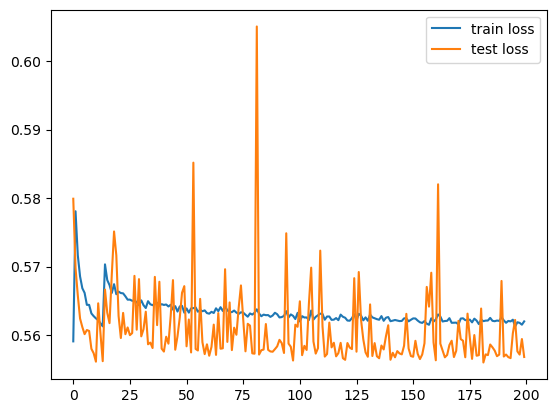

In [126]:
plt.plot(results['train loss'], label='train loss')
plt.plot(results['test loss'], label='test loss')
plt.legend()
plt.savefig('best_epoch_100_lr_0.03.png')
print (results)

In [127]:
checkpoint = torch.load('./best_epoch_100_lr_0.03.pt')
model.load_state_dict(checkpoint['model_state_dict'])
model.to(device)
model.eval()

def pref(_x):
    with torch.no_grad():
        _x = torch.as_tensor(_x, dtype=torch.float32).cpu().clone().detach()
        Y_logits = model(_x).clone().detach()
        print (Y_logits, type(Y_logits))
        y_hat = np.argmax(Y_logits)
        print (y_hat)

user_x_0 = torch.tensor(
    np.array([27.089,55.94,19,400,13010,19919,939.742,0.15,0.15,1.02,0.158,0.004,957]), 
    dtype =torch.float32).to(device) # 0
user_x_1 = torch.tensor(
    np.array([-1.144,48.22,1325,408,12986,19394,938.809,2.08,2.16,14.33,2.235,0.05,24499]),
    dtype =torch.float32).to(device) # 1

pref(user_x_0)
pref(user_x_1)

tensor([-0.3990,  0.5838]) <class 'torch.Tensor'>
tensor(1)
tensor([-0.3990,  0.5838]) <class 'torch.Tensor'>
tensor(1)


##### Your thougths and reflections here

In this section the neural network for smoke detection is designed and implemented. It is a classification problem, so the loss function is chosen as `CrossEntropyLoss`. I have tried several training methods where the structure of the network is consistent and the data set is split again and the number of epochs is changed.

For the training with the same epoch, the result including training loss and test loss is shown below. The reason of showing the difference between two training reuslts, is probably the `stratified sampling for class imbalance`. More specifically, the fire alarm (label == 1) account for 44757 (44757/62631 = 71.4%) in our dataset, therefore the model learns to simply reiterate the most common class label even if we randomly split the dataset. The trained model can always predict fire alarm (1) with high accuracy for the test data. That also means the overfitting for our dataset.

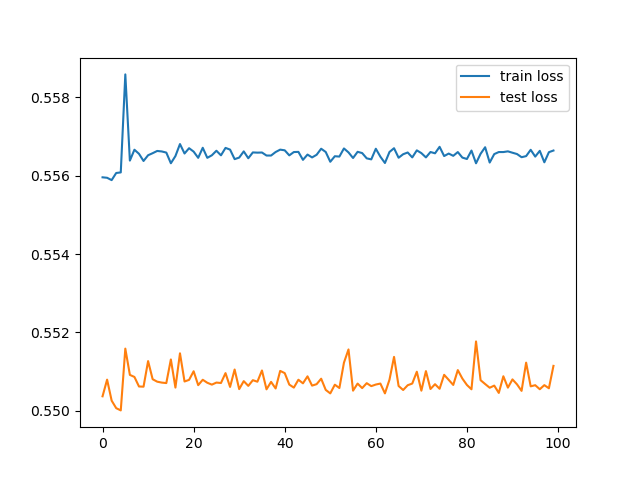

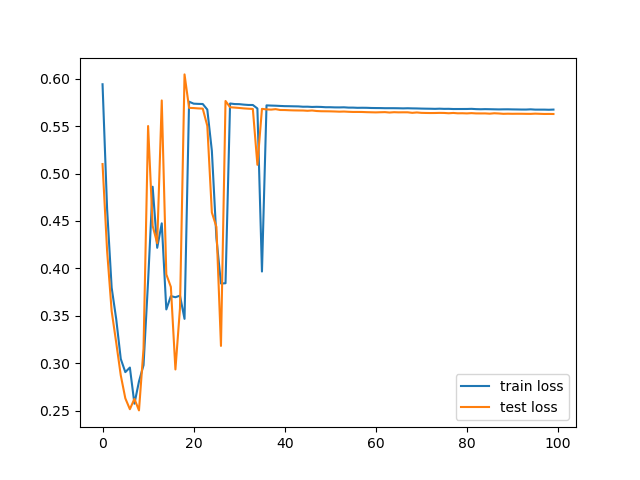

(None, None)

In [24]:
from PIL import Image
from IPython.display import display
img_0_epoch_100 = Image.open('0-epoch-100.png')
img_1_epoch_100 = Image.open('1-epoch-100.png')
display(img_0_epoch_100),display(img_1_epoch_100)

Second, I tried the training with more epochs, 300 and 500 epochs, while the dataset is the same, which means that the split did not run again. The results of this training are shown below. According to the results, I would like to say that the **100 of epoch** is enough to use for the current structure of the network.

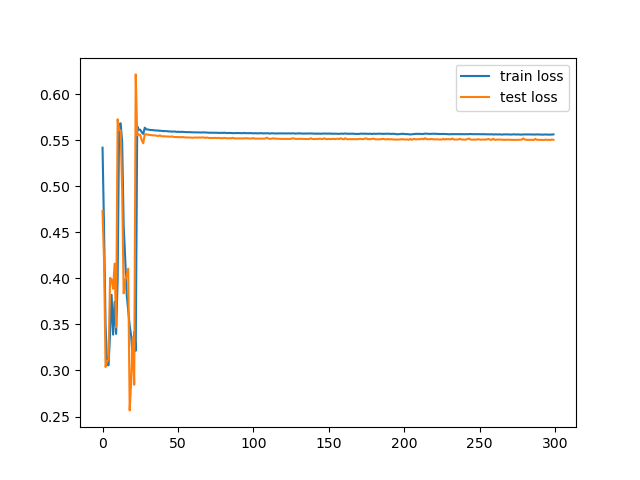

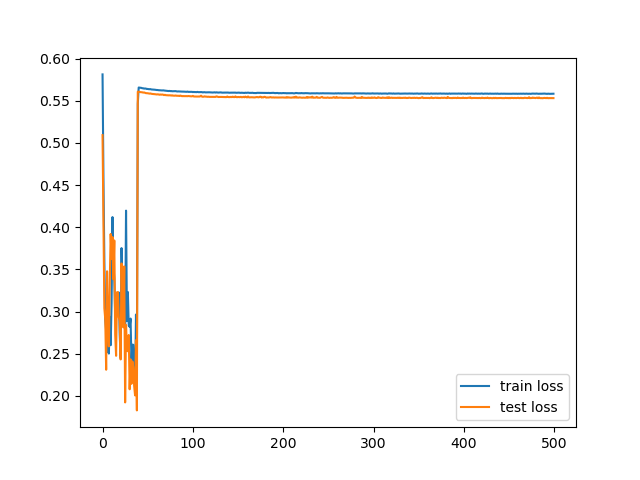

(None, None)

In [26]:
img_epoch_300 = Image.open('1-epoch-300.png')
img_epoch_500 = Image.open('0-epoch-500.png')
display(img_epoch_300),display(img_epoch_500)

I tried more tricks on training, the point is that I have to adjust more parameters such as the network layers, epochs and learning rate. So far, for this network, I found that the more epochs the network trains, the worse overfitting will be.
